Use traditional ML method of finding the best correlated feature(s)

In [1]:
import math
import sys
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.io import loadmat, savemat
from scipy import signal
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential,  Model
from keras.optimizers import Adam, SGD
from keras.layers import MaxPooling2D, Conv2D, MaxPooling1D, Conv1D, Dense, Flatten, AveragePooling1D, LSTM, Dropout, Input, Concatenate
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [2]:
data1 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean1.npz')
data2 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean2.npz')
data3 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean3.npz')
data4 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean4.npz')
data5 = np.load('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/NPData/Npclean5.npz')

In [3]:
def truncate(n,i):
  return math.floor(n*10**i)/10**i

train_time = np.concatenate((data1['Time'], data2['Time'], data3['Time'],data4['Time'], data5['Time']), axis=None)
ttime = [truncate(i,2) for i in train_time]
print(np.shape(ttime))
ttime = np.reshape(ttime, (np.shape(ttime)[0], 1))
print(ttime)
print(np.shape(ttime))

del train_time

train_data = np.concatenate((data1['AcData'], data2['AcData'], data3['AcData'], data4['AcData'], data5['AcData']), axis=0)
print(train_data)
print(np.shape(train_data))

del data1, data2, data3

ttime = pd.DataFrame(ttime).rename(columns={0:'Time'})
full_df = ttime.join(pd.DataFrame(train_data))
print(full_df)
del train_data, ttime

(1324032,)
[[2102.67]
 [2102.67]
 [2102.67]
 ...
 [3426.96]
 [3426.96]
 [3426.96]]
(1324032, 1)
[[ 21   9  26 ... -31 -33 -45]
 [ 17  20  28 ... -25 -30 -41]
 [  8  10  17 ... -17 -20 -38]
 ...
 [ 21  30  29 ... 232 242 238]
 [ 27  10  20 ... 248 239 228]
 [ 58  93 111 ... 249 224 216]]
(1324032, 1568)
            Time   0   1    2    3    4  ...  1562  1563  1564  1565  1566  1567
0        2102.67  21   9   26   20   31  ...   -11   -14   -25   -31   -33   -45
1        2102.67  17  20   28   24   29  ...   -10   -19   -26   -25   -30   -41
2        2102.67   8  10   17   13   32  ...   -15   -15   -19   -17   -20   -38
3        2102.67   2   5   14    8   17  ...    10     5   -18   -21   -35   -40
4        2102.67  15  15   10   22   29  ...   -13   -18   -18   -17   -24   -38
...          ...  ..  ..  ...  ...  ...  ...   ...   ...   ...   ...   ...   ...
1324027  3426.95  24  22   18   36   36  ...   250   258   253   233   231   232
1324028  3426.96  24  16   21   32   31  ...   2

In [4]:
# full_df = full_df.groupby(by='Time').mean().reset_index(drop=True).astype('float32').dtypes
# full_df['Time'] = full_df['Time'].shift(-1).fillna(truncate(full_df1.iloc[-1,0]+0.01,2))

full_df = full_df.drop_duplicates(subset=['Time'], keep='last').reset_index(drop=True)
full_df = full_df.set_index('Time')
print(full_df)

         0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
Time                                         ...                                    
2102.67    18    19     8    24    22    31  ...    -7   -13   -26   -29   -40   -47
2102.68    11    13    13    17    35    33  ...   -12   -18   -24   -25   -35   -38
2102.69    23    30    23    38    37    39  ...    -9   -18   -21   -25   -27   -38
2102.70    18    18    25    22    35    41  ...   -12   -16   -17   -22   -30   -30
2102.71    16    14    22    29    43    46  ...    -7    -5   -15   -28   -14   -36
...       ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
3426.92    24    15    13    25    32    32  ...   249   249   246   244   248   236
3426.93    16    15    27    21    49    32  ...   256   251   237   249   248   235
3426.94    11     1     6    17    23    28  ...   249   246   264   250   243   237
3426.95    24    22    18    36    36    26  ...   250   258   25

In [5]:
data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel()})
m_t = m_t[:][175604:175604+132400].reset_index(drop=True)
print(m_t)

           Time        SS
0       2102.91  5.657157
1       2102.92  5.658317
2       2102.93  5.659499
3       2102.94  5.660404
4       2102.95  5.661648
...         ...       ...
132395  3426.86  5.474545
132396  3426.87  5.478286
132397  3426.88  5.481751
132398  3426.89  5.484813
132399  3426.90  5.487332

[132400 rows x 2 columns]


In [6]:
df = full_df.reset_index().merge(m_t, on='Time').reset_index(drop=True)
xdf = df.drop(['Time', 'SS'], axis=1)
ydf = df[['SS']]
print(xdf)
print(ydf)

        0     1     2     3     4     5     ...  1562  1563  1564  1565  1566  1567
0          3    12    15    20    46    28  ...    -6   -11   -16   -23   -31   -40
1         15    16    13    29    33    39  ...    -6    -9   -15   -15   -25   -42
2          9    18     9    28    44    29  ...   -15   -13   -23   -27   -28   -25
3         22    31    17    24    41    27  ...    -3    -6   -18   -25   -24   -28
4         18    17    19    17    37    35  ...   -18   -16   -20   -26   -35   -44
...      ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...
132370    25    37    15    19    39    30  ...   256   246   251   242   224   227
132371    20    14     7    10    27    18  ...   258   259   245   238   230   231
132372    22     9    17    27    33    29  ...   260   249   235   241   234   219
132373    14    19    17    25    33    36  ...   259   260   252   253   256   235
132374    28    23    20    34    31    33  ...   251   244   237   236   22

In [7]:
xdf1 = np.reshape(np.array(xdf), (xdf.shape[0], xdf.shape[1], 1))

In [8]:

ps = 70     # Tunable parameter
  
m1 = MaxPooling1D(pool_size=ps,strides=2)(xdf1)
print(m1.shape)

(132375, 750, 1)


In [9]:
m = pd.DataFrame(tf.squeeze(m1).numpy())
print(m.shape)

(132375, 750)


In [10]:
df2 = m.join(ydf)
print(df2)

         0    1    2    3    4    5  ...  745  746  747  748  749        SS
0       46   95  175  271  380  466  ...  227  227  227  227  227  5.657157
1       39  103  167  271  367  468  ...  223  223  223  223  223  5.658317
2       44   94  185  274  363  457  ...  228  228  228  228  228  5.659499
3       41  102  176  289  379  456  ...  228  228  228  228  228  5.660404
4       37   90  170  269  368  459  ...  222  222  222  222  222  5.661648
...     ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...
132370  39   39   47  144  212  317  ...  262  262  262  262  262  5.474545
132371  32   32   41  132  227  285  ...  260  263  263  263  263  5.478286
132372  34   34   51  131  218  291  ...  266  266  266  266  266  5.481751
132373  36   36   58  137  223  302  ...  271  271  271  271  271  5.484813
132374  34   34   45  122  225  292  ...  259  259  259  259  259  5.487332

[132375 rows x 751 columns]


In [11]:
sp_corr = df2.corr(method='spearman')['SS'][:-1]
max_val = max(sp_corr)
#min_val = min(sp_corr)
print(max_val)
cols_ind = list(sp_corr[sp_corr == max(sp_corr)].index)
print(cols_ind)


0.2886323815268818
[626]


(750,)


Text(0.5, 1.0, 'Plot of filtered amplitude with highest correlation')

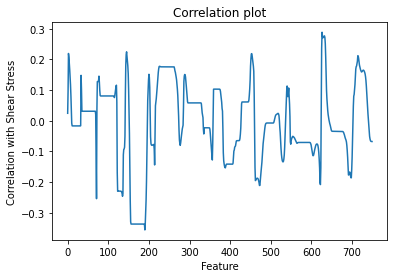

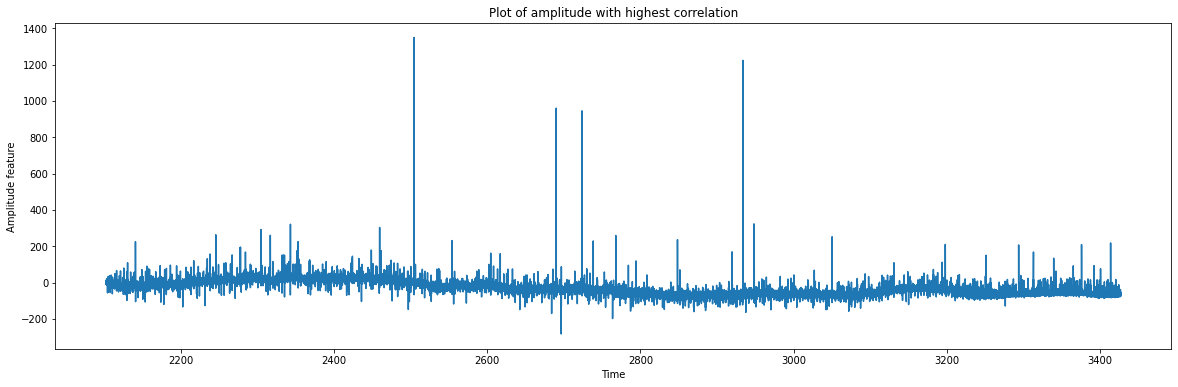

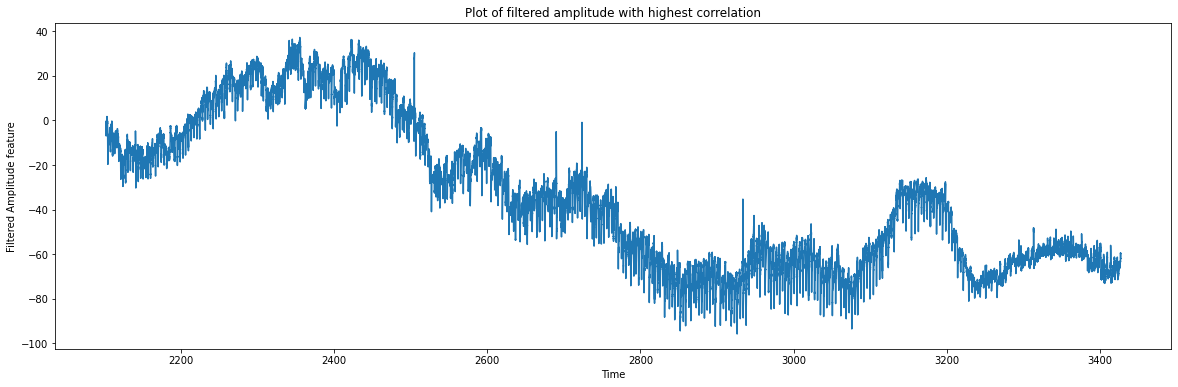

In [12]:
# sn.heatmap(sp_corr, annot=True)
# plt.show()
featamp = df2[cols_ind]

featamp2 = featamp.rolling(40, min_periods=1).mean().astype('float32')

print(np.shape(sp_corr))
plt.plot(sp_corr)
plt.xlabel('Feature')
plt.ylabel('Correlation with Shear Stress')
plt.title('Correlation plot')

fig = plt.figure(2, figsize=(20,6))
plt.plot(df['Time'], featamp)
plt.xlabel('Time')
plt.ylabel('Amplitude feature')
plt.title('Plot of amplitude with highest correlation')

fig = plt.figure(3, figsize=(20,6))
plt.plot(df['Time'], featamp2)
plt.xlabel('Time')
plt.ylabel('Filtered Amplitude feature')
plt.title('Plot of filtered amplitude with highest correlation')


Text(0, 0.5, 'Amplitude feature')

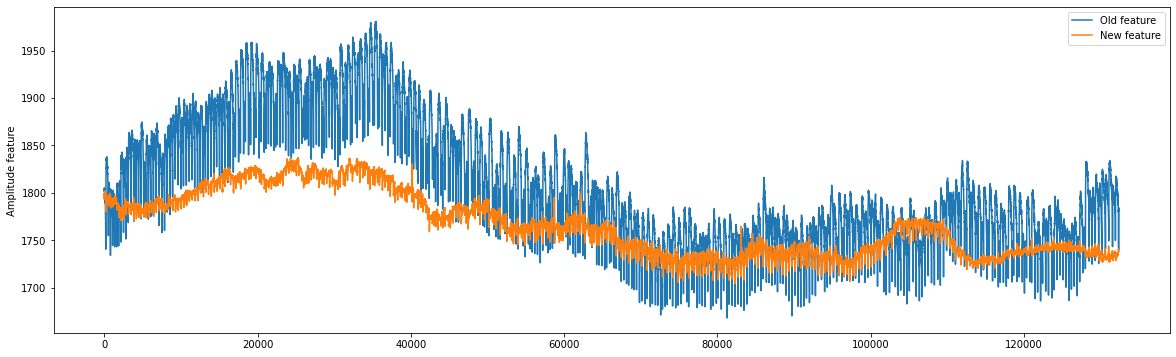

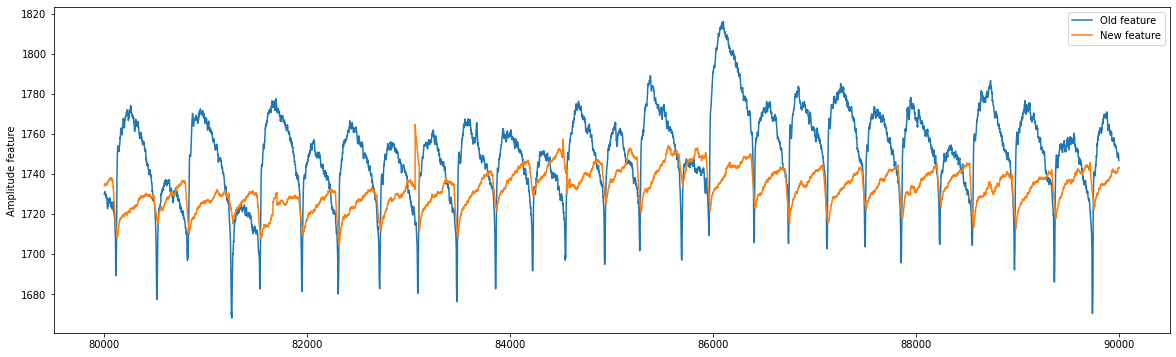

In [28]:
# Compared to old Amplitude feature

ampold = pd.DataFrame({'A_filt':data['A_filt'].ravel()})

fig = plt.figure(1, figsize=(20,6))
plt.plot(ampold)
plt.plot(featamp2+1800)  # Readjusted for comparison
plt.legend(['Old feature', 'New feature'])
plt.ylabel('Amplitude feature')


# Detailed plot
fig = plt.figure(2, figsize=(20,6))
plt.plot(ampold[80000:90000])
plt.plot(featamp2[80000:90000]+1800) 
plt.legend(['Old feature', 'New feature'])
plt.ylabel('Amplitude feature')



In [15]:
np.savez_compressed('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/Data_extraction/data/featamp.npz', Time=df['Time'], FeatAmp=featamp2)